# Stochastic Volatility model

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk

from scipy import optimize

Asset prices have time-varying volatility (variance of day over day `returns`). In some periods, returns are highly variable, while in others very stable. Stochastic volatility models model this with a latent volatility variable, modeled as a stochastic process. The following model is similar to the one described in the No-U-Turn Sampler paper, Hoffman (2011) p21.

$$ \sigma \sim Exponential(50) $$

$$ \nu \sim Exponential(.1) $$

$$ s_i \sim Normal(s_{i-1}, \sigma^{-2}) $$

$$ log(r_i) \sim t(\nu, 0, exp(-2 s_i)) $$

Here, $r$ is the daily return series and $s$ is the latent log volatility process.

## Build Model

First we load some daily returns of the S&P 500.

In [5]:
n = 400
returns = pd.read_hdf('../data/assets.h5', key='sp500/prices').loc['2000':, 'Close'].pct_change().dropna()
returns[:5]

Date
2000-01-04   -0.038345
2000-01-05    0.001922
2000-01-06    0.000956
2000-01-07    0.027090
2000-01-10    0.011190
Name: Close, dtype: float64

As you can see, the volatility seems to change over time quite a bit but cluster around certain time-periods. Around time-points 2500-3000 you can see the 2009 financial crash.

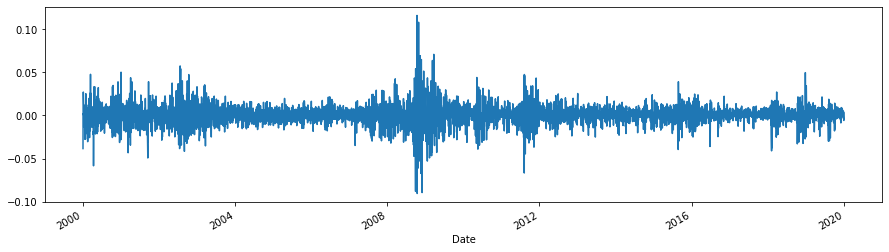

In [6]:
returns.plot(figsize=(15,4))

Specifying the model in `PyMC3` mirrors its statistical specification. 

In [7]:
with pm.Model() as model:
    step_size = pm.Exponential('sigma', 50.)
    s = GaussianRandomWalk('s', sd=step_size, shape=len(returns))
    
    nu = pm.Exponential('nu', .1)
    r = pm.StudentT('r', nu=nu, lam=pm.math.exp(-2*s), 
                    observed=returns)

## Fit Model

For this model, the full maximum a posteriori (MAP) point is degenerate and has infinite density. NUTS, however, gives the correct posterior.

In [ ]:
with model:
    trace = pm.sample(tune=2000, 
                      nuts_kwargs=dict(target_accept=.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, s, sigma]
Sampling 4 chains, 0 divergences:  33%|███▎      | 3346/10000 [03:11<05:55, 18.73draws/s]

In [ ]:
pm.traceplot(trace, varnames=['sigma', 'nu']);

In [ ]:
fig, ax = plt.subplots()

plt.plot(trace['s'].T, 'b', alpha=.03);
ax.set(title=str(s), xlabel='time', ylabel='log volatility');

Looking at the returns over time and overlaying the estimated standard deviation we can see how the model tracks the volatility over time.

In [ ]:
pm.trace_to_dataframe(trace).info()

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(returns.values)
ax.plot(np.exp(trace[s]).T, 'r', alpha=.03);
ax.set(xlabel='time', ylabel='returns')
ax.legend(['S&P500', 'stoch vol']);